In [1]:
### Build attribution model using Integrated Gradients algorithm for simple classifier that outputs argmin(i, j)

# Author: Qasim Wani
# Date Written: Feb. 8, 2021

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

## Generate Data

In [3]:
def generate_data():
    """Define function to compute the minimum class label of 5 16-bit integers. Return the corresponding oracle"""
    #define params
    min_value = np.iinfo(np.int16).min
    max_value = np.iinfo(np.int16).max
    
    C = 5 #number of input variable
    data = np.random.randint(low=min_value, high=max_value, size=(int(1e5), C))
    oracle = []
    for num in data:
        val = [0]*C
        val[np.argmax(num)] = 1
        oracle.append(val)
    
    return data, np.array(oracle).reshape(len(data), C)

In [4]:
X, y = generate_data()
#split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [5]:
### Create tensors from np.ndarry main data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

## Build Model

In [6]:
class Network(nn.Module):
    """3 layer ANN"""
    def __init__(self, C=5):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(C, 16)
        self.dp1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(16, 8)
        self.dp2 = nn.Dropout(p=0.3)
        self.output = nn.Linear(8, C)
    
    def forward(self, x):
        #Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp1(x)
        #Layer 2
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dp2(x)
        #Output Layer
        x = torch.sigmoid(self.output(x))
        return x

In [7]:
# seed the model for reproducibility (ideally across all nodes, later...)
torch.manual_seed(0)
model = Network().to(device)

In [8]:
# implement backprop
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

## Train model

In [9]:
def train(epochs=int(5e3), epsilon=0.1):
    """
    Train the model. Assumes access to global variables X_train, X_test, y_train, y_test, loss function & optim.
    """
    start_time = time.time()
    losses = []
    
    for i in tqdm(range(epochs)):
        y_pred = model(X_train)
        loss = loss_function(y_pred, torch.max(y_train, 1)[1])
        losses.append(loss)
        
        if loss.item() < epsilon:
            print(f"Model Converged at epoch {i + 1}, loss = {loss.item()}")
            break
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Total training time (sec): {time.time() - start_time}, loss - {loss.item()}")
    
    return losses

In [10]:
cost = train()

100%|██████████| 5000/5000 [02:53<00:00, 28.85it/s]

Total training time (sec): 173.33308601379395, loss - 1.1146210432052612


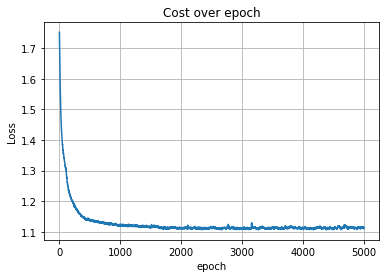

In [11]:
#graph cost
plt.plot(cost)
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Cost over epoch")
plt.grid()
plt.show()

## Test Model

In [12]:
#### predict X_test data
predictions=[]
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())
        
predictions = np.array(predictions, dtype=np.int16)

In [13]:
### compute metrics
score = accuracy_score(torch.max(y_test, 1)[1], predictions)
print("Accuracy", score)

Accuracy 0.7520666666666667
